In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from pycaret.regression import *

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [19]:
# ADD TIME FEATURES
def add_time_features(df, time_column):
    
    df[time_column] = pd.to_datetime(df[time_column])  # Make sure the time column is in datetime format
    
    # Extract various time features
    df['hour'] = df[time_column].dt.hour
    df['day_of_week'] = df[time_column].dt.dayofweek
    df['month'] = df[time_column].dt.month
    df['day_of_year'] = df[time_column].dt.dayofyear
    df['week_of_year'] = df[time_column].dt.isocalendar().week 

    # Transform hour to sine/cosine components
    df['sin_hour'] = np.sin(np.pi * df['hour']/24.)
    #df['cos_hour'] = np.cos(np.pi/2 * df['hour']/24.)

    # Transform month to sine/cosine components
    #df['sin_month'] = np.sin(np.pi * df['month']/12.)
    #df['cos_month'] = np.cos(np.pi/2 * df['month']/12.)

    # Drop the original hour and month columns (optional)
    df = df.drop(columns=['hour'])#, 'month'])
    
    return df

In [20]:
# PREPROCESSING
def preprocessing(targets, observed, estimated, test):
   
    # Ensure the datetime columns are in datetime format
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])

    # Resample observed, estimated, and test data to 1 hour using mean() as aggregator
    # and drop rows where all columns are NaN
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    
    '''mean_values_targets = targets.mean()
    mean_values_observed = observed_resampled.mean()
    mean_values_estimated = estimated_resampled.mean()
    mean_values_test = test_resampled.mean()

    # Fill the NaNs
    targets.fillna(mean_values_targets, inplace=True)
    observed_resampled.fillna(mean_values_observed, inplace=True)
    estimated_resampled.fillna(mean_values_estimated, inplace=True)
    test_resampled.fillna(mean_values_test, inplace=True)'''

    # Merge the observed and estimated data
    weather_data = pd.concat([observed_resampled, estimated_resampled])

    # Merge with target values
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')

    # Add the time-based features
    merged_data = add_time_features(merged_data, 'time')  
    test_resampled = add_time_features(test_resampled, 'date_forecast') 
    
    # Drop non-feature columns
    merged_data = merged_data.drop(columns=['time', 'date_forecast', 'pv_measurement'])
    
    return merged_data, test_resampled

In [21]:
from pycaret.regression import *
def process_location(X, y, location_name):
    # Combine feature data and target into a single DataFrame
    data = X.copy()
    data['target'] = y

    # Setup the environment in PyCaret
    exp_reg = setup(data=data, target='target', session_id=123,
                    categorical_features=['dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx'],
                    #remove_outliers=True,  #Ble dårligere med denne
                    #outliers_threshold=0.01, #default er 5%, prøver med kun fjerne 1% outliers
                    html=False,
                    #silent=True,  
                    experiment_name=f'exp_{location_name}')

    # Create a LightGBM model
    lightgbm = create_model('lightgbm')

    # Tune the model
    tuned_lightgbm = tune_model(lightgbm)

    # Create a bagged version of the tuned model
    bagged_lightgbm = ensemble_model(tuned_lightgbm, method='Bagging')

    # Finalize the model - this will train it on the complete dataset
    final_model = finalize_model(bagged_lightgbm)

    # Save the model for future use
    save_model(final_model, f'final_model_for_location_{location_name}')

    return final_model

                    Description        Value
0                    Session id          123
1                        Target       target
2                   Target type   Regression
3           Original data shape  (34061, 51)
4        Transformed data shape  (34061, 67)
5   Transformed train set shape  (23842, 67)
6    Transformed test set shape  (10219, 67)
7              Numeric features           47
8          Categorical features            3
9                    Preprocess         True
10              Imputation type       simple
11           Numeric imputation         mean
12       Categorical imputation         mode
13     Maximum one-hot encoding           25
14              Encoding method         None
15               Fold Generator        KFold
16                  Fold Number           10
17                     CPU Jobs           -1
18                      Use GPU        False
19               Log Experiment        False
20              Experiment Name        exp_A
21        

           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     197.3354  177169.9649  420.9156  0.8709  1.2559  1.4580
1     192.7477  174822.4394  418.1177  0.8676  1.2611  1.2874
2     183.5941  153190.7411  391.3959  0.8845  1.3115  1.3965
3     184.4146  155923.9030  394.8720  0.8919  1.1129  1.8972
4     196.8841  185888.5081  431.1479  0.8638  1.3983  1.6659
5     197.7662  199182.8986  446.2991  0.8528  1.3103  1.5356
6     195.0764  197594.8727  444.5164  0.8576  1.2571  1.6373
7     191.0462  167528.6401  409.3026  0.8784  1.2536  1.3289
8     195.1860  171773.6005  414.4558  0.8762  1.2308  1.3337
9     197.4951  205496.0113  453.3167  0.8503  1.3676  1.3210
Mean  193.1546  178857.1580  422.4340  0.8694  1.2759  1.4862
Std     5.0171   17045.9464   20.1666  0.0130  0.0748  0.1871


Fitting 10 folds for each of 10 candidates, totalling 100 fits


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     197.7309  178184.9717  422.1196  0.8701  1.4230  1.7484
1     189.8953  167423.1375  409.1737  0.8732  1.4699  1.4493
2     181.9706  152844.7538  390.9536  0.8847  1.4548  1.8491
3     180.0962  146933.2491  383.3187  0.8982  1.3910  2.0945
4     196.0490  180561.3013  424.9251  0.8677  1.4972  2.5290
5     195.3583  188471.4787  434.1330  0.8607  1.4030  1.6613
6     195.2682  187879.5487  433.4507  0.8646  1.4247  2.3360
7     189.8932  159727.5432  399.6593  0.8840  1.4679  1.5498
8     192.2104  169213.1715  411.3553  0.8781  1.3277  1.4511
9     194.1550  195223.5327  441.8411  0.8577  1.4492  1.3993
Mean  191.2627  172646.2688  415.0930  0.8739  1.4308  1.8068
Std     5.6710   15312.6353   18.5487  0.0118  0.0462  0.3738


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     190.8063  167573.7522  409.3577  0.8779  1.1453  1.3427
1     185.9017  165090.2723  406.3130  0.8750  1.1272  1.2490
2     177.9320  150318.4463  387.7092  0.8866  1.1305  1.4016
3     175.4547  143445.6850  378.7422  0.9006  1.0725  1.5150
4     191.6065  182112.1484  426.7460  0.8666  1.1887  1.8951
5     191.9664  188828.2943  434.5438  0.8604  1.1576  1.3910
6     187.7046  187505.0894  433.0186  0.8648  1.1683  1.6497
7     186.8504  159677.5864  399.5968  0.8841  1.1307  1.1908
8     192.7333  168757.8395  410.8015  0.8784  1.0946  1.2394
9     193.9311  203909.0207  451.5629  0.8514  1.1340  1.1393
Mean  187.4887  171721.8134  413.8392  0.8746  1.1349  1.4014
Std     5.9678   17771.8730   21.4233  0.0135  0.0320  0.2201
Transformation Pipeline and Model Successfully Saved
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. C

          MAE        MSE     RMSE      R2   RMSLE     MAPE
Fold                                                      
0     35.7145  5429.6529  73.6862  0.8571  1.4589  38.4063
1     36.1008  5557.9567  74.5517  0.8464  1.4637   2.1166
2     35.8960  4989.1768  70.6341  0.8765  1.4893   1.4146
3     34.1157  4757.6400  68.9756  0.8659  1.5054   1.7941
4     36.3970  5726.7684  75.6754  0.8482  1.5278   1.8189
5     36.3479  5607.6803  74.8844  0.8579  1.4897   1.3744
6     35.3951  5321.3093  72.9473  0.8743  1.4892   1.2663
7     34.2389  4631.7796  68.0572  0.8645  1.5544   1.5907
8     34.3164  4537.3103  67.3596  0.8781  1.4828   1.6726
9     33.9268  4594.0447  67.7794  0.8837  1.5381   1.9267
Mean  35.2449  5115.3319  71.4551  0.8653  1.4999   5.3381
Std    0.9397   440.1060   3.0825  0.0122  0.0297  11.0256


Fitting 10 folds for each of 10 candidates, totalling 100 fits


          MAE        MSE     RMSE      R2   RMSLE     MAPE
Fold                                                      
0     34.6081  5264.2304  72.5550  0.8614  1.4078  41.8007
1     34.3763  5478.3593  74.0159  0.8486  1.4293   2.0224
2     33.8198  4826.8651  69.4756  0.8806  1.4357   1.2538
3     32.7804  4604.5888  67.8571  0.8702  1.4296   1.5362
4     35.2664  5446.6873  73.8017  0.8556  1.4588   1.6021
5     34.2218  5362.7168  73.2306  0.8641  1.4435   1.2868
6     34.3898  5247.8070  72.4417  0.8760  1.4250   1.1657
7     32.4294  4342.3000  65.8961  0.8729  1.4667   1.3568
8     33.3627  4454.3862  66.7412  0.8803  1.4286   1.6659
9     32.9808  4503.0843  67.1050  0.8860  1.4869   1.5388
Mean  33.8236  4953.1025  70.3120  0.8696  1.4412   5.5229
Std    0.8623   428.0967   3.0536  0.0114  0.0221  12.0949


          MAE        MSE     RMSE      R2   RMSLE     MAPE
Fold                                                      
0     34.5701  5388.2360  73.4046  0.8582  1.3577  14.7892
1     34.6438  5528.7265  74.3554  0.8472  1.3951   1.8540
2     33.8158  4819.4630  69.4224  0.8807  1.3927   1.2132
3     33.0313  4867.6517  69.7686  0.8628  1.3751   1.5399
4     34.3668  5418.5756  73.6110  0.8563  1.4044   1.5078
5     34.7319  5424.8825  73.6538  0.8625  1.3962   1.2831
6     33.4283  5112.1457  71.4993  0.8792  1.3800   1.1393
7     32.5812  4473.1832  66.8819  0.8691  1.4257   1.4607
8     33.3254  4430.1912  66.5597  0.8810  1.3834   1.4594
9     31.7549  4327.5954  65.7845  0.8905  1.4117   1.5415
Mean  33.6249  4979.0651  70.4941  0.8688  1.3922   2.7788
Std    0.9387   435.7361   3.1060  0.0130  0.0184   4.0080
Transformation Pipeline and Model Successfully Saved
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [W

          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     29.4890  3245.8373  56.9723  0.8390  1.5810  0.6933
1     31.7176  3798.5166  61.6321  0.8375  1.5174  0.7365
2     28.3654  2994.5313  54.7223  0.8546  1.5390  0.6536
3     31.6582  3815.7070  61.7714  0.8456  1.5381  0.7748
4     30.3290  3728.9659  61.0653  0.8132  1.5847  0.6002
5     28.8567  3024.2513  54.9932  0.8706  1.4839  0.6348
6     30.6070  3552.4826  59.6027  0.8619  1.5266  0.8478
7     29.9340  3078.3298  55.4827  0.8615  1.5411  0.7219
8     28.4704  3078.2484  55.4820  0.8500  1.5739  0.6165
9     30.6120  3266.8453  57.1563  0.8480  1.5549  0.6766
Mean  30.0039  3358.3716  57.8880  0.8482  1.5441  0.6956
Std    1.1461   316.2044   2.7108  0.0153  0.0296  0.0728


Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     28.1747  3534.9245  59.4552  0.8247  1.4372  0.6647
1     30.1742  3921.5806  62.6225  0.8322  1.3869  0.6732
2     27.0825  3138.9689  56.0265  0.8475  1.4462  0.6458
3     30.2545  3719.0127  60.9837  0.8495  1.4172  0.7526
4     28.5979  3679.5305  60.6591  0.8157  1.4560  0.5510
5     27.5802  3200.9484  56.5769  0.8631  1.3696  0.5782
6     28.9853  3498.0923  59.1447  0.8641  1.4118  0.7552
7     28.6815  3103.6776  55.7107  0.8603  1.4152  0.6944
8     26.5303  3000.7079  54.7787  0.8538  1.4315  0.5602
9     28.1429  3081.7599  55.5136  0.8566  1.4265  0.5911
Mean  28.4204  3387.9203  58.1472  0.8467  1.4198  0.6466
Std    1.1430   305.7118   2.6129  0.0160  0.0249  0.0712


          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     30.0584  3395.9987  58.2752  0.8316  1.5603  0.7055
1     32.4190  4031.0161  63.4903  0.8275  1.5225  0.7882
2     28.9073  3136.7810  56.0070  0.8477  1.5338  0.6832
3     31.4534  3581.8297  59.8484  0.8551  1.5278  0.8060
4     30.3673  3706.4051  60.8803  0.8143  1.5706  0.6065
5     29.1386  3143.8870  56.0704  0.8655  1.4716  0.6418
6     30.9216  3625.2153  60.2098  0.8591  1.5310  0.8596
7     30.1650  3101.9563  55.6952  0.8604  1.5495  0.7362
8     28.8252  3113.9970  55.8032  0.8483  1.5664  0.6287
9     30.6272  3289.1601  57.3512  0.8469  1.5422  0.6903
Mean  30.2883  3412.6246  58.3631  0.8456  1.5376  0.7146
Std    1.0889   298.6742   2.5249  0.0155  0.0271  0.0783
Transformation Pipeline and Model Successfully Saved
Index(['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'cle

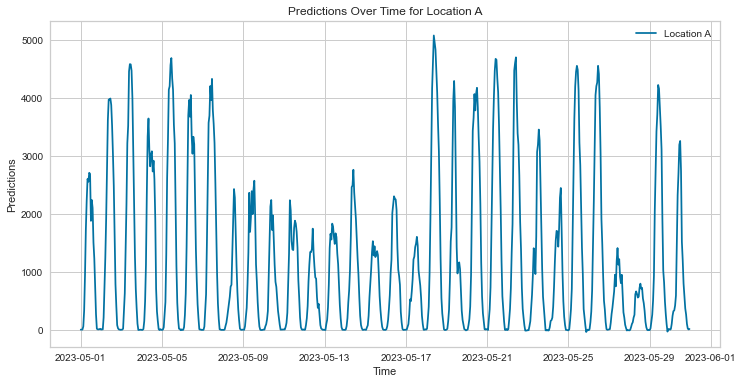

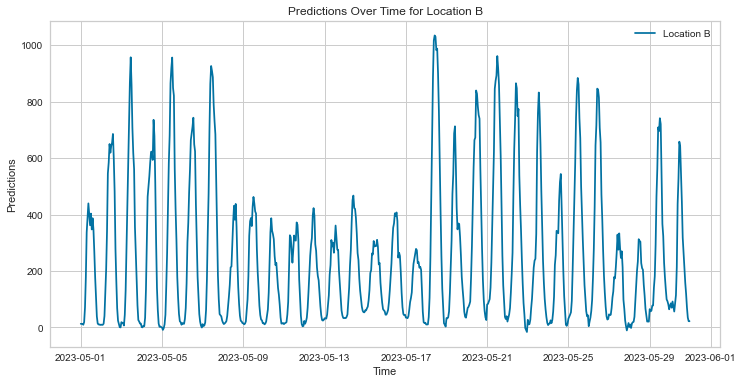

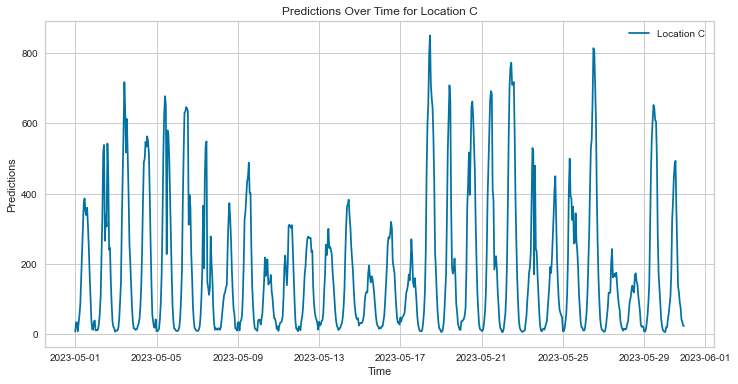

In [22]:
locations = ['A', 'B', 'C']
all_predictions = []
final_df_list = [] 


for loc in locations:
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)
    y_train = train['pv_measurement'].values

    # Ensure X and y have the same length
    min_length = min(len(X_train), len(y_train))
    X_train, y_train = X_train.iloc[:min_length], y_train[:min_length]

    # Process the location data and get the final model
    final_model = process_location(X_train, y_train, loc)

    # Predict on new data
    predictions = predict_model(final_model, data=X_test)
    print(predictions.columns)

    # Store predictions
    all_predictions.append(predictions['prediction_label'])  

    # Prepare dataframe for visualization
    num_predictions = len(predictions)
    timestamps = pd.date_range(start='2023-05-01 00:00:00', periods=num_predictions, freq='H')

    df = pd.DataFrame({
        'time': timestamps,
        'prediction': predictions['prediction_label'],
        'location': loc
    })

    final_df_list.append(df)

# Concatenate all the individual data frames and prepare for plotting
final_df = pd.concat(final_df_list, ignore_index=True)
final_df['time'] = pd.to_datetime(final_df['time'])
final_df.sort_values('time', inplace=True)

# Visualization
for loc in locations:
    # Filter data for each location
    temp_df = final_df[final_df['location'] == loc]
    
    plt.figure(figsize=(12, 6))  # Create a new figure for each location
    plt.plot(temp_df['time'], temp_df['prediction'], label=f'Location {loc}')
    plt.xlabel('Time')
    plt.ylabel('Predictions')
    plt.title(f'Predictions Over Time for Location {loc}')
    plt.legend()
    plt.show()

# If you need to save the final dataframe without 'time' and 'location' columns, you can do so before plotting
final_df_save = final_df.copy()
final_df_save = final_df_save.drop(columns=['time', 'location'])

In [23]:
'''sample_submission = pd.read_csv('sample_submission.csv')
sample_submission
sample_submission = sample_submission[['id']].merge(final_df[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv('my_first_submission.csv', index=False)'''

final_predictions = np.concatenate(all_predictions)

# Save the final_predictions to CSV
df = pd.DataFrame(final_predictions, columns=['prediction'])
df['id'] = df.index
df = df[['id', 'prediction']]
df.to_csv('final_predictions.csv', index=False)